Introdução

Implementar um algoritmo de machine learning capaz de separar grandes quantidades de imagens, em tamanho grande, de acordo com suas respectivas categorias.

Perceber os conceitos de redes neurais, os pré-requisitos para correta implementação e seus trade-offs.



Sobre o Dataset

Imagens de diferentes paisagens, classificadas em 6 diferentes categorias:
- Buildings
- Forest
- Glacier
- Mountain
- Sea
- Street

O dataset possui aproximadamente 25k imagens no total, divididas em:
- 14k para treino
- 3k para teste
- 7k para predição

O objetivo principal neste notebook é implementar uma rede neural, utilizando tensorFlow e a API Keras.

As imagens tem dimensão de 150 x 150.

Seguindo o tutorial: https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras, estarei seguindo a seguinte ordem lógica para aprendizado:

1. Verificar e importar as bibliotecas necessárias
2. Importar o dataset, visualizar amostras aleatórias e realizar pré-processamento
3. Implementar um modelo simples e inicial de CNN, e validar sua performance
4. Verificar os resultados, a implementação e possíveis melhorias.

Importando as bibliotecas necessárias para a implementação

In [2]:
#%% Importing packages
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd

Definição de labels e definição do tamanho de cada imagem.

In [3]:

class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Carregando o dataset

Nota: importante realizar o download do dataset. O tamanho total é consideravelmente grande.

Extrair os respectivos datasets para a pasta input, ou então alterar o path, conforme necessário.

Seguindo o tutorial, é desenvolvida uma função para realizar o carregamento do dataset, chamada load_data.

In [4]:
#%%LOADING THE DATA
"""
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

def load_data():
    
    datasets = ['./input/seg_train/seg_train', './input/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

Utilizar a função load_data(), para se obter os dados de treino e teste.

Em seguida, embaralhar os dados, de forma randômica.

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

Loading ./input/seg_train/seg_train


100%|██████████| 2382/2382 [00:04<00:00, 571.69it/s]


Loading ./input/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 560.51it/s]


Explorando o dataset

- Verificar as amostras de treino e teste
- Verificar o tamanho das imagens
- Verificar a proporção e ocorrência de cada categoria

In [6]:

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


Visualização de dados

- Proporção de imagens de treino e teste, distribuídas para cada categoria
- Proporção de imagens por categoria, para verificar se os dados estão balanceados.

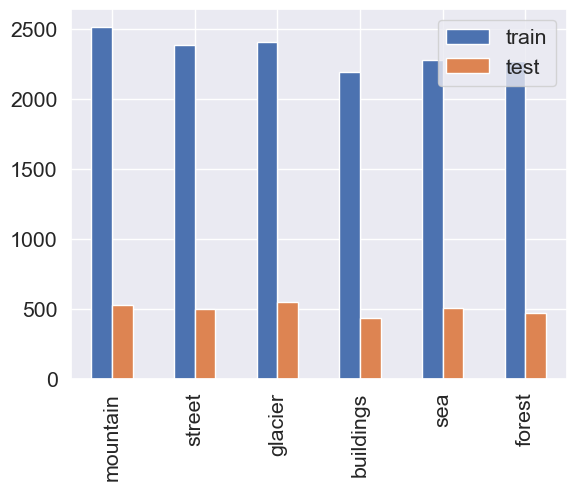

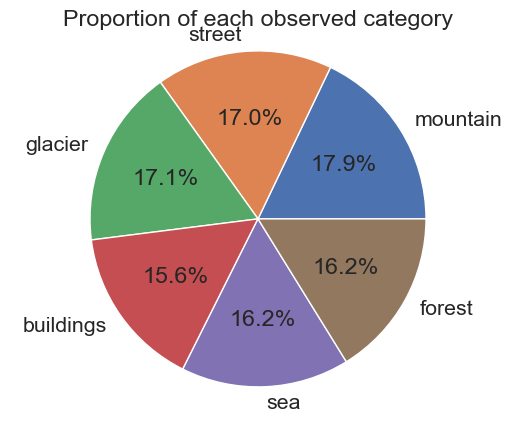

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
            'test': test_counts}, 
            index=class_names
            ).plot.bar()
plt.show()

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

train_images = train_images / 255.0 
test_images = test_images / 255.0

Visualizar imagens, de maneira aleatória

É definida uma função específica para escolha de uma imagem aleatória do array de imagens e sua correspondente label, de acordo com o index.

Também é definida outra função para a visualização de 25 imagens de forma aleatória, chamada display_examples.


In [8]:
"""
    Display a random image from the images array and its correspond label from the labels array.
"""
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    

Utilizara função display_random_image.

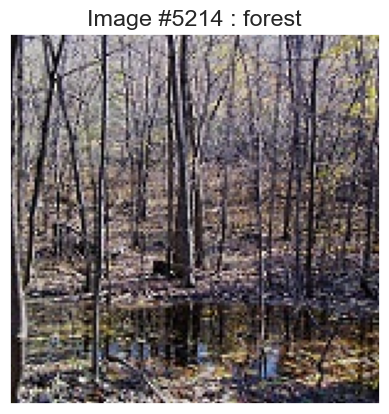

In [9]:
display_random_image(class_names, train_images, train_labels)

In [10]:
"""
    Display 25 images from the images array with its corresponding labels
"""
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    

Executar a função display_examples.

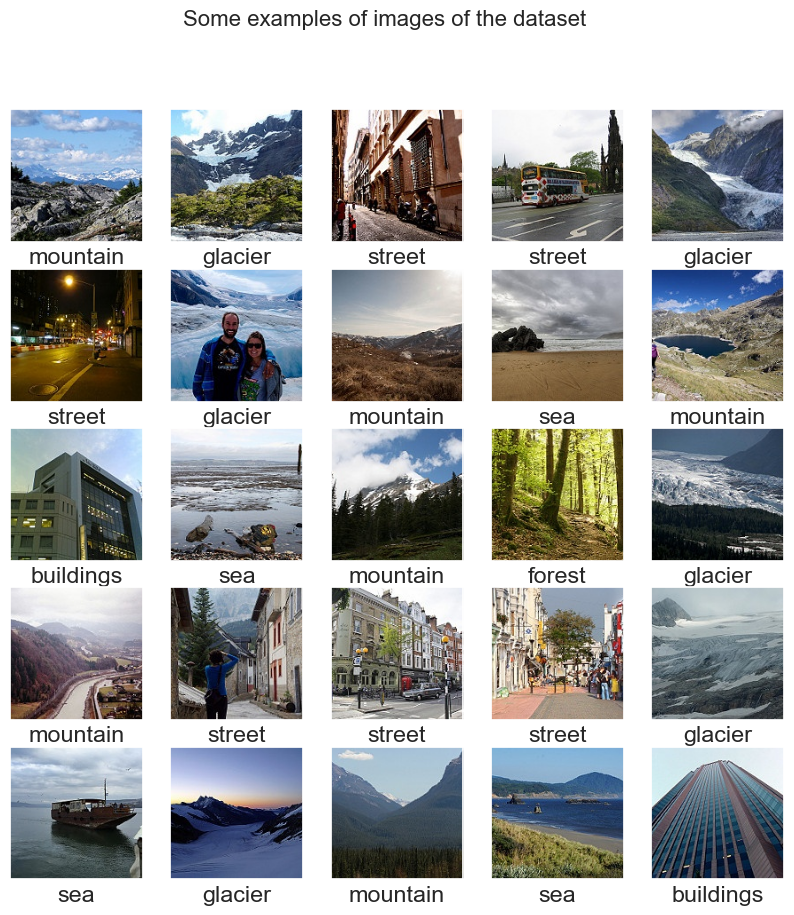

In [11]:
display_examples(class_names, train_images, train_labels)


Criação de modelo CNN básico

De acordo com a documentação do Keras, a variável model é inicializada como um modelo sequencial, adicionando camadas de forma linear, seguindo a ordem dos itens do array, do menor ao maior índice.

Características do modelo

Camadas convolucionais iniciais:
- A primeira camada convolucional 2D é adicionada, com 32 filtros, cada um no tamanho de 3x3 e com uma função de ativação ReLU. Também passamos como argumento para esta camada de entrada as dimensões de input (imagens), com suas respectivas dimensões e o canal de cor (RGB).
- Camada seguinte, de duas dimensões e tamanho 2x2, chamada MaxPooling, para redução de dimensão espacial do dado.

Camadas convolucionais adicionais:
- Seguindo modelos já conhecidos e testados, conforme indicação.

Camada Flat:
- Transforma a saída da camada anterior, de dimensão 2D para um vetor de dimensão 1D, como forma de preparo para as camadas seguintes.

Camadas Densas:
- Adição de 128 camadas com função de ativação ReLU
- Camada de saída, de acordo com o número de classes do problema de classificação, neste caso, 6.



In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Compilação do modelo CNN inicial e suas respectivas camadas

- optimizer='adam': O otimizador é o algoritmo usado para atualizar os pesos da rede neural durante seu treinamento. Neste caso, 'adam' refere-se ao algoritmo de otimização gradient descent
- loss='sparse_categorical_crossentropy': A função de perda é uma medida de quão bem o modelo está se saindo. 'sparse_categorical_crossentropy' é um tipo específico de função de perda usada para tarefas de classificação multi-classe quando os rótulos são fornecidos como inteiros. Ela calcula a perda de entropia cruzada entre a distribuição de probabilidade prevista e a verdadeira distribuição de probabilidade das classes.
- metrics=['accuracy']: As métricas são usadas para avaliar o desempenho do modelo. Neste caso, a métrica 'accuracy' é usada para monitorar a precisão da classificação do modelo durante o treinamento e a avaliação. Ela calcula a proporção de imagens classificadas corretamente em relação ao número total de imagens.

In [13]:
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics=['accuracy'])

Seguindo a lógica já vista em outros modelos de classificação, após a análise dos dados, pré-processamento, realizaremos o treino do modelo e sua validação com os dados de teste e predição, verificando a nota de desempenho, relacionado com as imagens corretamente classificadas em relação ao total de imagens.

Fit dos dados de treino

In [14]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)


Epoch 1/20


88/88 [==============================] - 31s 318ms/step - loss: 1.3079 - accuracy: 0.5480 - val_loss: 0.8822 - val_accuracy: 0.6555
Epoch 2/20
88/88 [==============================] - 25s 286ms/step - loss: 0.7438 - accuracy: 0.7264 - val_loss: 0.7241 - val_accuracy: 0.7289
Epoch 3/20
88/88 [==============================] - 26s 295ms/step - loss: 0.6170 - accuracy: 0.7782 - val_loss: 0.6662 - val_accuracy: 0.7538
Epoch 4/20
88/88 [==============================] - 26s 297ms/step - loss: 0.5257 - accuracy: 0.8134 - val_loss: 0.6346 - val_accuracy: 0.7706
Epoch 5/20
88/88 [==============================] - 26s 291ms/step - loss: 0.4269 - accuracy: 0.8540 - val_loss: 0.6242 - val_accuracy: 0.7777
Epoch 6/20
88/88 [==============================] - 25s 289ms/step - loss: 0.3252 - accuracy: 0.8904 - val_loss: 0.7190 - val_accuracy: 0.7481
Epoch 7/20
88/88 [==============================] - 27s 305ms/step - loss: 0.2435 - accuracy: 0.9231 - val_loss: 0.6552 - val_accuracy: 0.78

Avaliar desempenho

Com uma função específica para avaliar o desempenho do modelo, após seu treino com o dataset de treino.

In [21]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    

Utilizando a função de verificação de desempenho, com o modelo treinado, armazenado na variável history.

{'loss': [1.3079310655593872, 0.7437675595283508, 0.616960883140564, 0.5256776809692383, 0.426890105009079, 0.32515233755111694, 0.24350027740001678, 0.17650331556797028, 0.13291582465171814, 0.09311852604150772, 0.058266691863536835, 0.04359548166394234, 0.037593644112348557, 0.028823139145970345, 0.020032117143273354, 0.02158414199948311, 0.02393319085240364, 0.02429213561117649, 0.021202947944402695, 0.07920002192258835], 'accuracy': [0.5479647517204285, 0.7263739109039307, 0.7782132625579834, 0.8133962750434875, 0.854012668132782, 0.8904426693916321, 0.9231317639350891, 0.948160707950592, 0.9635699391365051, 0.9752382636070251, 0.9896677732467651, 0.9918054938316345, 0.9927852749824524, 0.9960808753967285, 0.9975950717926025, 0.9973278641700745, 0.996169924736023, 0.9962590336799622, 0.9971497058868408, 0.9764852523803711], 'val_loss': [0.8822141289710999, 0.7241044640541077, 0.6661781668663025, 0.6345659494400024, 0.6241785287857056, 0.7190253734588623, 0.6552125811576843, 0.71101

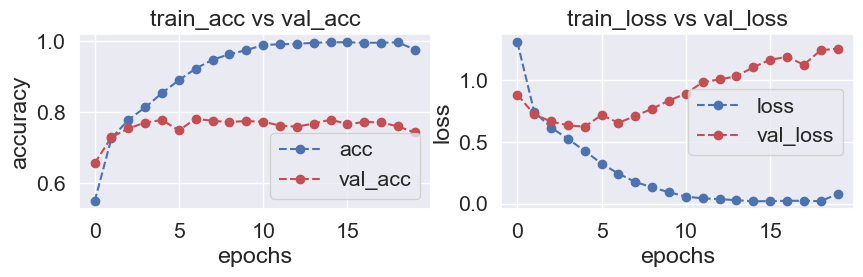

In [22]:
print(history.history)
plot_accuracy_loss(history)


Validação com os dados de teste

In [23]:
test_loss = model.evaluate(test_images, test_labels)
print(test_loss)

94/94 [==============================] - 2s 22ms/step - loss: 1.2576 - accuracy: 0.7527
[1.2575792074203491, 0.7526666522026062]


Verificar o desempenho do modelo em imagens aleatórias

94/94 [==============================] - 2s 20ms/step


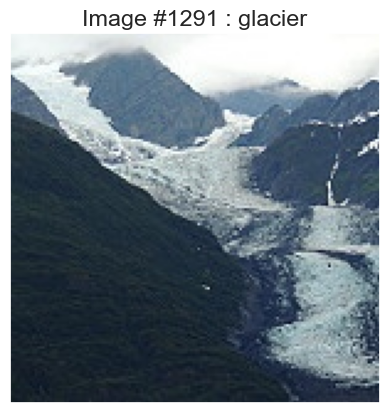

In [24]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

Análise de erros na predição

Para possibilitar a avaliação do modelo nas imagens em que classificou de forma erronea, é definida uma função para visualizar 25 imagens do conjunto de imagens com classificação falha.

Em seguida, utilizamos a função confusion_matrix para verificar a correlação entre as imagens de teste e predição, através do label, já que as imagens podem ser acessadas através de index.

In [25]:
#%% MISLABELED IMAGES
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

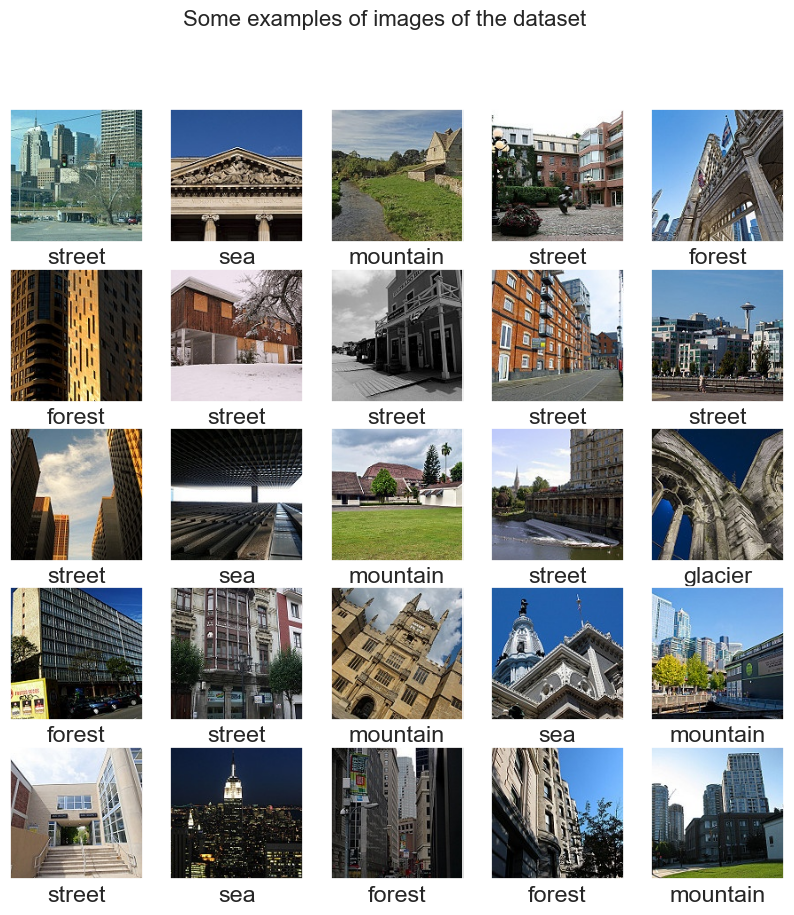

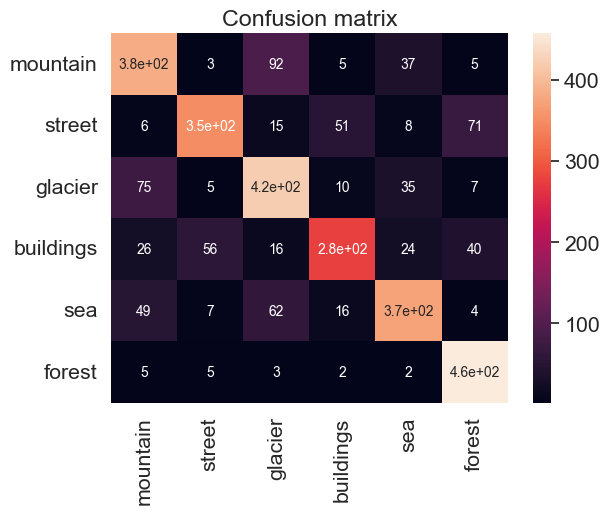

In [26]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
    annot_kws={"size": 10}, 
    xticklabels=class_names, 
    yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Conclusão

De acordo com a matrix de correlação, é possível verificar que o modelo possui dificuldades em reconhecer imagens da categoria building, que possuem streets, assim como dificuldade em distinguir entre mar, geleiras e montanhas. Porém tem melhor desempenho em distinguir imagens de florestas.